In [1]:
import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
#from scipy.interpolate import interp1d
from tetrahedrafunc import *
import readgadget 
from scipy.spatial import cKDTree
import os

mycosmospar = {'H0': 70.3,
 'Ob0': 0.045, 
 'Om0': 0.276,
 'flat': True,
 'ns': 0.961,
 'sigma8': 0.811}
mycosmos =  cosmology.setCosmology("mycosmos", **mycosmospar)

oakdir="/oak/stanford/orgs/kipac/users/xinshuo/"
testsnapdir=oakdir+"test20220708/"

rlist = np.power(10.0,np.arange( -1,1.41, 0.1 )) # 25 radius points to estimate \xi

In [46]:
mytetsize=4
fileidx = 62
denseN = 500
xshift = 0
yshift = 0
zshift = 0
rid   = 21
sampleNcen = 20
sampleNsph = 100

sampleradius = rlist[rid]

outputdir = testsnapdir + "outputs_snap%03d_tet%d_N%d_x%d_y%d_z%d_batch%d/"%(fileidx,mytetsize,denseN,xshift,yshift,zshift,0)
plotdir = outputdir+"plots/"
corrdir = outputdir+"xi_rid%d_cen%d_sph%d/"%(rid,sampleNcen,sampleNsph)

In [47]:
# read the delta fields
Ndim=128
xx=np.arange(Ndim)[0:Ndim:mytetsize]
Ndimtet=len(xx)
Nconn = 6 * (Ndimtet-1)**3
Nbatchs = int(Nconn/(200000 * (150/denseN)**3))+1
Nperbatch = int(Nconn/Nbatchs)
celllen = 250.0 /Ndim
# dense grid is where we paint the density fields
x = celllen*Ndim/denseN*(0.5+np.arange(denseN))
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
denseGrid=np.vstack([xl,yl,zl]).transpose()
deltafield = np.zeros(denseN**3)
for idx in range(Nbatchs):
    print(idx)
    batchidx_start = idx * Nperbatch
    batchidx_end = (idx+1) * Nperbatch-1
    if idx == Nbatchs-1:
        batchidx_end = Nconn-1
    outputdir = testsnapdir + "outputs_snap%03d_tet%d_N%d_x%d_y%d_z%d_batch%d/"%(fileidx,mytetsize,denseN,xshift,yshift,zshift,batchidx_start)
    dfbatch = np.load(outputdir+"deltafield.npy")
    deltafield = deltafield + dfbatch +1
deltafield = deltafield -1

# Use points that have values
treefield=deltafield[np.where(deltafield!=-1)[0]]
treepts = denseGrid[np.where(deltafield!=-1)[0]]
# to build KDTree which we will use to interpolate fields
mytree = cKDTree(treepts)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


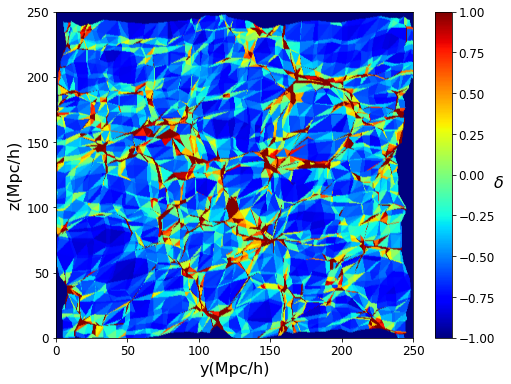

In [48]:
# plot a layer of the sample points
from matplotlib  import cm

selected_xlayer = 50
plt.figure().set_size_inches([8,6])

plt.scatter(denseGrid[selected_xlayer*denseN**2:(selected_xlayer+1)*denseN**2,1],
            denseGrid[selected_xlayer*denseN**2:(selected_xlayer+1)*denseN**2,2],
            c = deltafield[selected_xlayer*denseN**2:(selected_xlayer+1)*denseN**2] ,
            s=2, cmap = cm.jet, vmin=-1,vmax=1 )
plt.xlim(0,250)
plt.ylim(0,250)
cbar=plt.colorbar()
cbar.ax.set_ylabel('$\\delta$',fontsize=16,rotation=0)
cbar.ax.tick_params(labelsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('y(Mpc/h)',fontsize=16)
plt.ylabel('z(Mpc/h)',fontsize=16)
#plt.savefig('deltafield_snap%03d_tetsize%d_xlayer%d.pdf'%(fileidx,mytetsize,selected_xlayer),bbox_inches='tight')
plt.show()

got densities


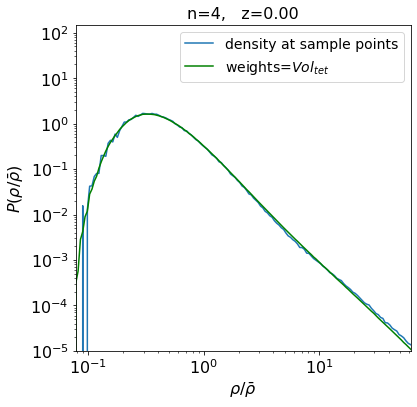

In [56]:
# check density PDF
mydata = np.ravel( np.load(testsnapdir+"snapshot_%03d.npy"%fileidx,allow_pickle=True) )[0]
Loc_sorted  = mydata["Loc_sorted"]
Loc_shifted = mydata["Loc_shifted"]
Ndim        = mydata["Ndim"]
currentz    = mydata["currentz"]
celllen     = mydata["celllen"]

rhoavg = 1/(celllen**3)

# Lagrangian grid points
x = celllen*(0.5+np.arange(Ndim))
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
gridPoints=np.vstack([xl,yl,zl]).transpose()

#reshape into a 3d mesh so as to refer xid,yid,zid more easily
grid3d=np.stack(xg,axis=3)
Loc3d=Loc_shifted.reshape(Ndim,Ndim,Ndim,3) 

# get vol
vol = get_tet_volumes_anysize(Ndim-mytetsize,Loc3d,mytetsize)
volflat=vol.reshape(((Ndim-mytetsize)**3,6))
dens_vol = (mytetsize**3)/np.abs( volflat.ravel() )/6
print("got densities")

# compare with volume-weighted PDF
plt.figure().set_size_inches([6,6])

dm,rhobins=np.histogram(deltafield[np.where(deltafield!=-1)[0]]+1,bins=np.power(10.0,np.arange( -2,5, 0.02 )),density=True)
rhoxaxis=(rhobins[0:dm.shape[0]]+rhobins[1:dm.shape[0]+1])/2
plt.loglog(rhoxaxis,dm,label='density at sample points')

dm,rhobins=np.histogram(dens_vol/rhoavg,bins=np.power(10.0,np.arange( -2,5, 0.02 )),density=True,weights=1/dens_vol)
rhoxaxis=(rhobins[0:dm.shape[0]]+rhobins[1:dm.shape[0]+1])/2
plt.loglog(rhoxaxis,dm,'g',label='weights=$Vol_{tet}$') # /len(primDen) to normalize
xr=rhoxaxis[np.where(dm>1e-5)[0][-1]]
xl=rhoxaxis[np.where(dm>1e-5)[0][0]]

plt.xlim(xl,xr)
plt.ylim(1e-5,150)
plt.legend(fontsize=14)

plt.xlabel('$\\rho/\\bar{\\rho}$',fontsize=16)
plt.ylabel('$ P(\\rho/\\bar{\\rho} )$',fontsize=16)
plt.title('n=%d,   z=%.2f'%(mytetsize,currentz),fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [49]:
# estimate correlation
sampleliml=50.0
samplelimr=200.0
x = sampleliml +sampleradius + (samplelimr-sampleliml-2*sampleradius)/sampleNcen*(0.5+np.arange(sampleNcen))
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
samplePcen = np.vstack([xl,yl,zl]).transpose() # sample of centers
samplePsph = fibonacci_sphere(sampleNsph) #sample of sphere points for each center
samplexi = [] # sample of the pair correlation function \xi (r)
cnt =0 
for centerP in samplePcen:
    if cnt%1000 ==0:
        print(cnt)
    cnt+=1
    deltacen = treefield[mytree.query(centerP)[1]]
    sphereP = centerP + sampleradius*samplePsph
    deltasph = treefield[mytree.query(sphereP)[1]]
    samplexi = np.append(samplexi,deltacen*deltasph)

0
1000
2000
3000
4000
5000
6000
7000


In [50]:
deltacen

-0.7124269789983905

In [51]:
deltasph

array([-4.92091268e-01, -4.92091268e-01, -2.25474815e-01, -3.50605644e-01,
        8.87419389e-01, -7.46349687e-02, -6.87453818e-01, -1.14084988e-01,
       -4.18029567e-01, -4.64291267e-01, -1.66895937e-01, -3.99252051e-01,
       -2.90725476e-01, -3.21088552e-01, -4.64291267e-01, -1.82415246e-01,
       -4.18029567e-01, -3.75953605e-01,  7.18451870e-01, -2.04689811e-01,
       -2.90725476e-01,  4.84747239e-01, -9.44003980e-02, -1.82415246e-01,
        2.99233870e-01,  1.23761489e-01,  3.79994722e+00, -6.54611537e-01,
       -2.90725476e-01, -7.17698355e-02, -5.19162224e-01,  3.18174814e+00,
       -2.84249892e-02,  1.23761489e-01, -2.72932167e-01, -4.67224667e-01,
        4.39243619e-02,  1.37250410e+00, -4.15478095e-01, -3.97536822e-01,
       -6.33659209e-01,  1.23761489e-01, -2.72932167e-01, -6.37920145e-01,
        7.41711439e-01,  2.24019437e+01, -6.60434504e-01,  5.44366550e-01,
       -2.77927722e-01,  4.07642535e-01,  2.89610151e+00, -5.91265529e-01,
       -3.97536822e-01, -

In [52]:
np.mean(samplexi)

0.17303616755352436

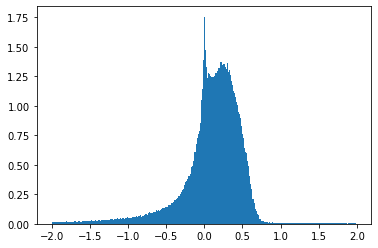

In [53]:
plt.hist(samplexi,bins = np.arange(-2,2,0.01),density=True)
plt.show()

In [54]:
# plot xi-r curve
meanxi =[]
stdxi  =[]
for sampleradius in np.power(10.0,np.arange( -1,1.5, 0.1 )):
    # estimate correlation
    sampleliml=50.0
    samplelimr=200.0
    x = sampleliml +sampleradius + (samplelimr-sampleliml-2*sampleradius)/sampleNcen*(0.5+np.arange(sampleNcen))
    xg = np.meshgrid(x,x,x, indexing='ij')
    xl = np.ravel(xg[0])
    yl = np.ravel(xg[1])
    zl = np.ravel(xg[2])
    samplePcen = np.vstack([xl,yl,zl]).transpose() # sample of centers
    samplePsph = fibonacci_sphere(sampleNsph) #sample of sphere points for each center
    samplexi = [] # sample of the pair correlation function \xi (r)
    cnt =0 
    for centerP in samplePcen:
        if cnt%1000 ==0:
            print(cnt)
        cnt+=1
        deltacen = treefield[mytree.query(centerP)[1]]
        sphereP = centerP + sampleradius*samplePsph
        deltasph = treefield[mytree.query(sphereP)[1]]
        samplexi = np.append(samplexi,deltacen*deltasph)
    meanxi.append(np.mean(samplexi))
    stdxi.append(np.std(samplexi))

0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000


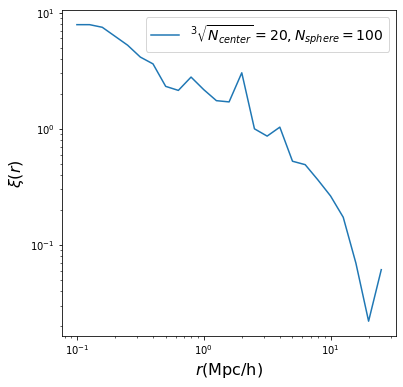

In [55]:

plt.figure().set_size_inches([6,6])
plt.loglog(rlist,meanxi,label = '$^3\\sqrt{N_{center}}=%d, N_{sphere}=%d$'%(sampleNcen,sampleNsph))
plt.xlabel('$r$(Mpc/h)',fontsize=16)
plt.ylabel('$ \\xi (r) $'%sampleradius,fontsize=16)
plt.legend(fontsize=14)
plt.show()

<Figure size 432x432 with 0 Axes>

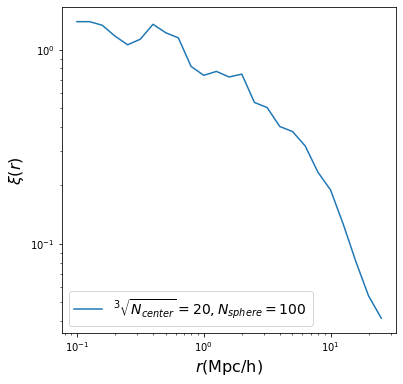

In [45]:

plt.figure().set_size_inches([6,6])
plt.loglog(rlist,meanxi,label = '$^3\\sqrt{N_{center}}=%d, N_{sphere}=%d$'%(sampleNcen,sampleNsph))
plt.xlabel('$r$(Mpc/h)',fontsize=16)
plt.ylabel('$ \\xi (r) $'%sampleradius,fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [57]:
# check the stability of xi against sampleNsph and sampleNcen

stabcheck = []

for sampleNcen in [5,10,15,20]:
    for sampleNsph in [10,30,60,100]:
        sampleliml=50.0
        samplelimr=200.0
        sampleradius = 5
        x = sampleliml +sampleradius + (samplelimr-sampleliml-2*sampleradius)/sampleNcen*(0.5+np.arange(sampleNcen))
        xg = np.meshgrid(x,x,x, indexing='ij')
        xl = np.ravel(xg[0])
        yl = np.ravel(xg[1])
        zl = np.ravel(xg[2])

        samplePcen = np.vstack([xl,yl,zl]).transpose() # sample of centers
        samplePsph = fibonacci_sphere(sampleNsph) #sample of sphere points for each center

        samplexi = [] # sample of the pair correlation function \xi (r)
        cnt =0 
        for centerP in samplePcen:
            if cnt%1000 ==0:
                print(cnt)
            cnt+=1
            deltacen = treefield[mytree.query(centerP)[1]]
            sphereP = centerP + sampleradius*samplePsph
            deltasph = treefield[mytree.query(sphereP)[1]]
            samplexi = np.append(samplexi,deltacen*deltasph)

        stabcheck.append([sampleNcen,sampleNsph, np.mean(samplexi), np.std(samplexi)])

0
0
0
0
0
0
0
0
0
1000
2000
3000
0
1000
2000
3000
0
1000
2000
3000
0
1000
2000
3000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000


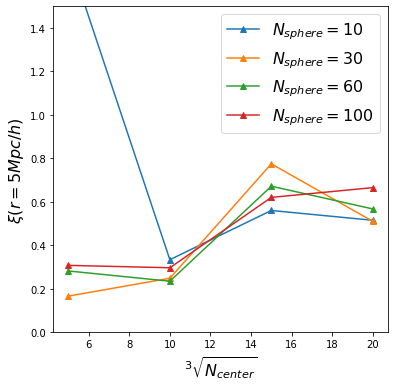

In [59]:
stabcheck=np.array(stabcheck)
plt.figure().set_size_inches([6,6])
plt.plot(stabcheck[0::4,0],stabcheck[0::4,2],marker='^',label='$N_{sphere} = 10$')
plt.plot(stabcheck[1::4,0],stabcheck[1::4,2],marker='^',label='$N_{sphere} = 30$')
plt.plot(stabcheck[2::4,0],stabcheck[2::4,2],marker='^',label='$N_{sphere} = 60$')
plt.plot(stabcheck[3::4,0],stabcheck[3::4,2],marker='^',label='$N_{sphere} = 100$')

plt.ylim(0,1.5)
plt.xlabel('$^3\\sqrt{N_{center}}$',fontsize=16)
plt.ylabel('$ \\xi (r= %.0f Mpc/h) $'%sampleradius,fontsize=16)
plt.legend(fontsize=16)
plt.show()